# Predicting Prices of Real Estate Listings
Using the data gathered in the data wrangling notebook (scraped and wrangled from the Danish Real Estate Company Home). Let's try to predict the listing prices based on the features available.

## Questions
* How much does location matter?
* Is it possible to predict listing prices based on characteristics of the home?
* If so, what features are most important?

## Exploring the dataset
Before diving into the machine learning component let's learn a bit more about the data.

* Preparing the data
* Translating stuff
* Typecasting
* Plotting 


In [719]:
# Loading libraries
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn import linear_model, tree, preprocessing, ensemble, model_selection
import os
import graphviz

In [720]:
# Add Path for Graphviz
os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz2.38\\bin"

In [721]:
df = pd.read_csv('home_data_clean_final.csv', index_col = 0)
df.reset_index(inplace = True)
df.head()

index                         Address  Area           City       HomeType  \
0      0   A.D. Jørgensens Vej 75, 2. 1.  35.0  Frederiksberg  Ejerlejlighed   
1      1   Holger Danskes Vej 14, 3. th.  46.0  Frederiksberg  Ejerlejlighed   
2     11              Lyøvej 5, st.. tv.  60.0  Frederiksberg  Ejerlejlighed   
3     12  H. Schneekloths Vej 13, 5. th.  56.0  Frederiksberg  Ejerlejlighed   
4     30            Howitzvej 61, 3. th.  67.0  Frederiksberg  Ejerlejlighed   

   isNew   Latitude  Longitude  PostalCode       Price  ... Sewers Basement  \
0  False  55.680726  12.494705        2000  1.350.000   ...    NaN      NaN   
1  False  55.686615  12.538356        2000  2.145.000   ...    NaN      NaN   
2  False  55.682940  12.524527        2000  2.875.000   ...    NaN      NaN   
3  False  55.679928  12.506927        2000  2.750.000   ...    NaN      NaN   
4   True  55.680209  12.523998        2000  3.195.000   ...    NaN      NaN   

  PriceDevelopment                                        Accessories Heating  \
0              -7%  Alle nuværende hårde hvidevarer i lejligheden ...     NaN   
1              -6%  Intuition gaskomfur komfur  - Matsui Fridge Do...     NaN   
2              -4%  emhætte -  bordkomfur glaskeramisk -  indbygni...     NaN   
3               0%  De i lejligheden hårde hvidevarer medfølger i ...     NaN   
4              NaN                                                NaN     NaN   

  Windows YearOfValuation Exterior  NetOwnerFee  GrossOwnerFee  
0     NaN          2018.0      NaN        5.249     4.628  kr.  
1     NaN          2018.0      NaN        8.313     7.331  kr.  
2     NaN          2018.0      NaN       10.446     9.212  kr.  
3     NaN          2018.0      NaN       10.075     8.884  kr.  
4     NaN             NaN      NaN          NaN            NaN  

[5 rows x 39 columns]

In [722]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 39 columns):
index                       8515 non-null int64
Address                     8515 non-null object
Area                        8505 non-null float64
City                        8515 non-null object
HomeType                    8515 non-null object
isNew                       8515 non-null bool
Latitude                    8221 non-null float64
Longitude                   8221 non-null float64
PostalCode                  8515 non-null int64
Price                       8515 non-null object
ID                          8515 non-null object
PaymentOnAccount            118 non-null object
DistanceToShopping          1227 non-null object
DistanceToTransportation    947 non-null object
DistanceToSchool            1013 non-null object
DistanceToForest            105 non-null object
DistanceToWater             338 non-null object
Balcony                     147 non-null object
Floors           

In [723]:
df.Toilets.unique()

array(['1', nan, '2', '3', '6', '5', '7', '1 stk.', '2 Stk.', '2 stk.',
       '3 stk.', '4'], dtype=object)

In [724]:
df.PriceDevelopment.unique()

array(['-7%', '-6%', '-4%', '0%', nan, '-2%', '-5%', '-8%', '-3%', '-10%',
       '-21%', '-9%', '-11%', '-12%', '-24%', '-1%', '-16%', '-25%',
       '-14%', '-22%', '-13%', '-19%', '-18%', '-23%', '-15%', '-20%',
       '3%', '-28%', '-26%', '-32%', '-29%', '-41%', '-47%', '-17%', '5%',
       '-31%', '-34%', '4%', '2%', '9%'], dtype=object)

There's a large difference in number of missing values and some data types that are off. We can start by making all the columns numeric, that should be numeric.

In [726]:
def extract_and_convert_numeric(df_var, col_list, decimal_sep):
    """
    Extract numeric information from a string column in a Pandas dataframe.
    Input:
    df_var: The Pandas Dataframe
    col_list: list of columns to be extracted and converted
    decimal_sep: The decimal_separator used in the data.
    Output:
    Dataframe with converted columns.
    """
    if decimal_sep == '.':
        thousand_sep = ','
    elif decimal_sep == ',':
        thousand_sep = '.'
    for col in col_list:
        try:
            df_var[col] = df_var[col].str.replace(thousand_sep, '').str.extract(r'(-?\d+)').astype('float64')
        except:
            print('Could not extract/convert the column {}'.format(col))
    return df_var

In [727]:
df = extract_and_convert_numeric(df,
                                 ['Price', 'DistanceToShopping',
                                  'DistanceToTransportation',
                                  'DistanceToForest','DistanceToWater',
                                  'DistanceToSchool','LivingArea',
                                  'EstateValue', 'GroundArea','Toilets',
                                  'PriceDevelopment','LandValue',
                                  'GrossOwnerFee'], ',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 39 columns):
index                       8515 non-null int64
Address                     8515 non-null object
Area                        8505 non-null float64
City                        8515 non-null object
HomeType                    8515 non-null object
isNew                       8515 non-null bool
Latitude                    8221 non-null float64
Longitude                   8221 non-null float64
PostalCode                  8515 non-null int64
Price                       8515 non-null float64
ID                          8515 non-null object
PaymentOnAccount            118 non-null object
DistanceToShopping          1227 non-null float64
DistanceToTransportation    947 non-null float64
DistanceToSchool            1013 non-null float64
DistanceToForest            105 non-null float64
DistanceToWater             338 non-null float64
Balcony                     147 non-null object
Floors     

In [730]:
df.head()

index                         Address  Area           City       HomeType  \
0      0   A.D. Jørgensens Vej 75, 2. 1.  35.0  Frederiksberg  Ejerlejlighed   
1      1   Holger Danskes Vej 14, 3. th.  46.0  Frederiksberg  Ejerlejlighed   
2     11              Lyøvej 5, st.. tv.  60.0  Frederiksberg  Ejerlejlighed   
3     12  H. Schneekloths Vej 13, 5. th.  56.0  Frederiksberg  Ejerlejlighed   
4     30            Howitzvej 61, 3. th.  67.0  Frederiksberg  Ejerlejlighed   

   isNew   Latitude  Longitude  PostalCode      Price  ... Sewers Basement  \
0  False  55.680726  12.494705        2000  1350000.0  ...    NaN      NaN   
1  False  55.686615  12.538356        2000  2145000.0  ...    NaN      NaN   
2  False  55.682940  12.524527        2000  2875000.0  ...    NaN      NaN   
3  False  55.679928  12.506927        2000  2750000.0  ...    NaN      NaN   
4   True  55.680209  12.523998        2000  3195000.0  ...    NaN      NaN   

   PriceDevelopment                                        Accessories  \
0              -7.0  Alle nuværende hårde hvidevarer i lejligheden ...   
1              -6.0  Intuition gaskomfur komfur  - Matsui Fridge Do...   
2              -4.0  emhætte -  bordkomfur glaskeramisk -  indbygni...   
3               0.0  De i lejligheden hårde hvidevarer medfølger i ...   
4               NaN                                                NaN   

   Heating  Windows  YearOfValuation Exterior  NetOwnerFee  GrossOwnerFee  
0      NaN      NaN           2018.0      NaN        5.249         4628.0  
1      NaN      NaN           2018.0      NaN        8.313         7331.0  
2      NaN      NaN           2018.0      NaN       10.446         9212.0  
3      NaN      NaN           2018.0      NaN       10.075         8884.0  
4      NaN      NaN              NaN      NaN          NaN            NaN  

[5 rows x 39 columns]

In [731]:
df.Toilets.unique()

array([ 1., nan,  2.,  3.,  6.,  5.,  7.,  4.])

In [732]:
df.PriceDevelopment.unique()

array([ -7.,  -6.,  -4.,   0.,  nan,  -2.,  -5.,  -8.,  -3., -10., -21.,
        -9., -11., -12., -24.,  -1., -16., -25., -14., -22., -13., -19.,
       -18., -23., -15., -20.,   3., -28., -26., -32., -29., -41., -47.,
       -17.,   5., -31., -34.,   4.,   2.,   9.])

Furthermore it's clear that we have a very high data quality on a few columns, whereas the remaining are somewhat sparsely filled out.

Let's check out the distribution of hometypes.

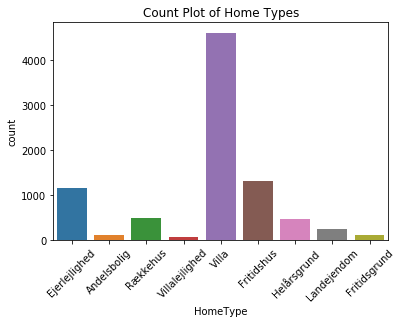

In [733]:
sb.countplot(data = df, x = 'HomeType')
plt.xticks(rotation = 45);
plt.title('Count Plot of Home Types');

Let's translate the categories to English.

In [734]:
df.HomeType = df.HomeType.str.replace('Ejerlejlighed', 'Apartment')
df.HomeType = df.HomeType.str.replace('Andelsbolig', 'Cooperative')
df.HomeType = df.HomeType.str.replace('Rækkehus', 'Row House')
df.HomeType = df.HomeType.str.replace('Villalejlighed', 'Garden apartment')
df.HomeType = df.HomeType.str.replace('Fritidshus', 'Cottage')
df.HomeType = df.HomeType.str.replace('Helårsgrund', 'Lot')
df.HomeType = df.HomeType.str.replace('Landejendom', 'Farmhouse') 
df.HomeType = df.HomeType.str.replace('Fritidsgrund', 'Cottage lot') #Excuse the English here: It's a piece of land reserved for cottage housing

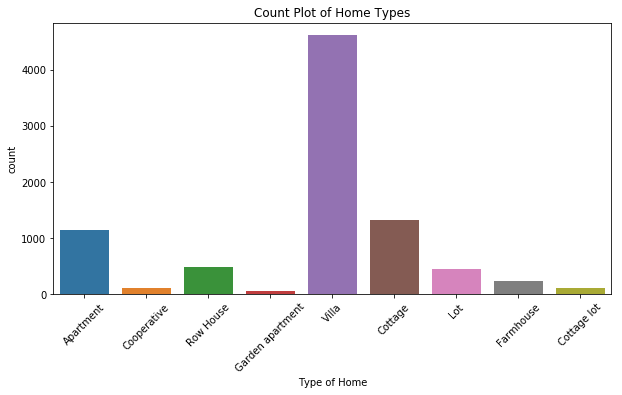

In [739]:
plt.figure(figsize = [10, 5])
sb.countplot(data = df, x = 'HomeType')
plt.xticks(rotation = 45);
plt.xlabel('Type of Home')
plt.title('Count Plot of Home Types');

Turns out part of the dataset doesn't contain housing, but merely the lots. Let's keep that in mind for later!

Let's check out the distribution of prices:

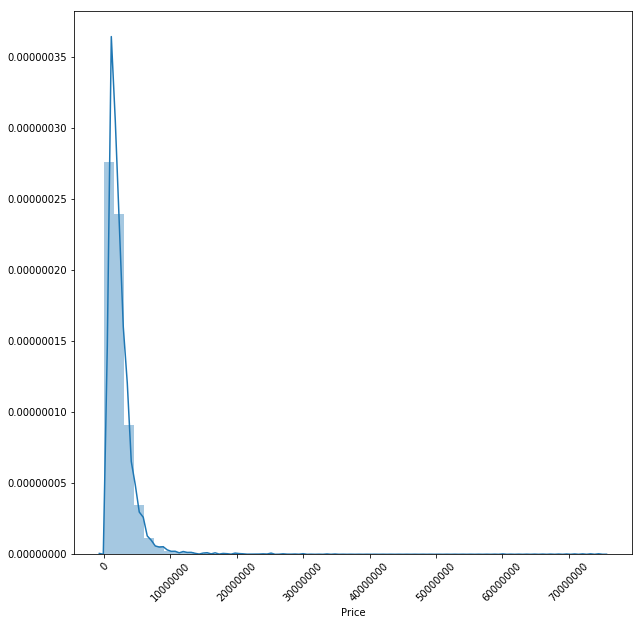

In [740]:
plt.figure(figsize = [10, 10])
sb.distplot(df.Price);
plt.xticks(rotation = 45) 
plt.ticklabel_format(style='plain')

Pretty right skewed - looks like we've got some expensive real estate (Prices are in DKK, for reference 1 USD ~ 7 DKK).
Let's look at a few:

In [741]:
df[df['Price'] > 30000000].head()

index                                            Address   Area  \
839    5384                                       Nybrovej 395  614.0   
985    6390  Tuborg Strand 1, 3., Tuborg Strandeng - Kysthus 1  250.0   
986    6391                                      Lemchesvej 14  425.0   
1059   6855                               Vedbæk Strandvej 328  901.0   

                City   HomeType  isNew   Latitude  Longitude  PostalCode  \
839   Kongens Lyngby      Villa  False  55.775475  12.461285        2800   
985         Hellerup  Apartment  False        NaN        NaN        2900   
986         Hellerup      Villa  False  55.735103  12.578140        2900   
1059          Vedbæk      Villa  False  55.842546  12.573132        2950   

           Price  ...                                        Sewers Basement  \
839   60000000.0  ...                                     Offentlig      NaN   
985   33500000.0  ...                                           NaN   35  m2   
986   35000000.0  ...                                           NaN      NaN   
1059  75000000.0  ...  Afløb til spildevandsforsyningens renseanlæg      NaN   

      PriceDevelopment                                        Accessories  \
839              -11.0                                              Ingen   
985               -5.0  Bosch køle/fryseskab - knækket håndtag (fryser...   
986                0.0  Siemens køleskab - Thermex emhætte - Siemens k...   
1059             -11.0  Zanussi køle-/fryseskabVoss komfurEcoline emhæ...   

                                                Heating  Windows  \
839   Kollektiv varmeforsyning/Solcellebaseret fjern...      NaN   
985                                                 NaN      NaN   
986                                                 NaN      NaN   
1059                                         Fjernvarme  Træ-alu   

      YearOfValuation Exterior  NetOwnerFee  GrossOwnerFee  
839            2017.0      NaN        2.039         1647.0  
985            2017.0      NaN        6.987         6125.0  
986            2018.0      NaN       12.360        10839.0  
1059           2017.0   Pudset        3.143         2712.0  

[4 rows x 39 columns]

Let's keep these four in mind - they may skew the eventual models we are to build.

Let's look at the area.

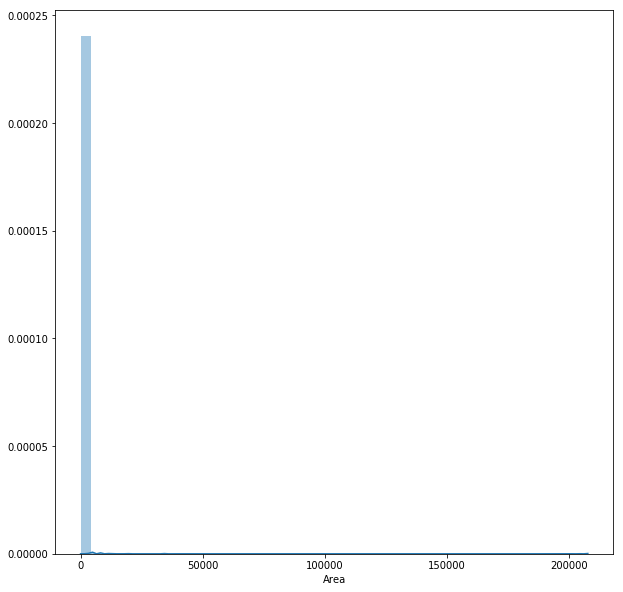

In [742]:
plt.figure(figsize = [10, 10])
sb.distplot(df.Area.dropna()); #Drop na in order to plot

Now that's not really that informative. Let's look at distribution of area for the different home types instead.

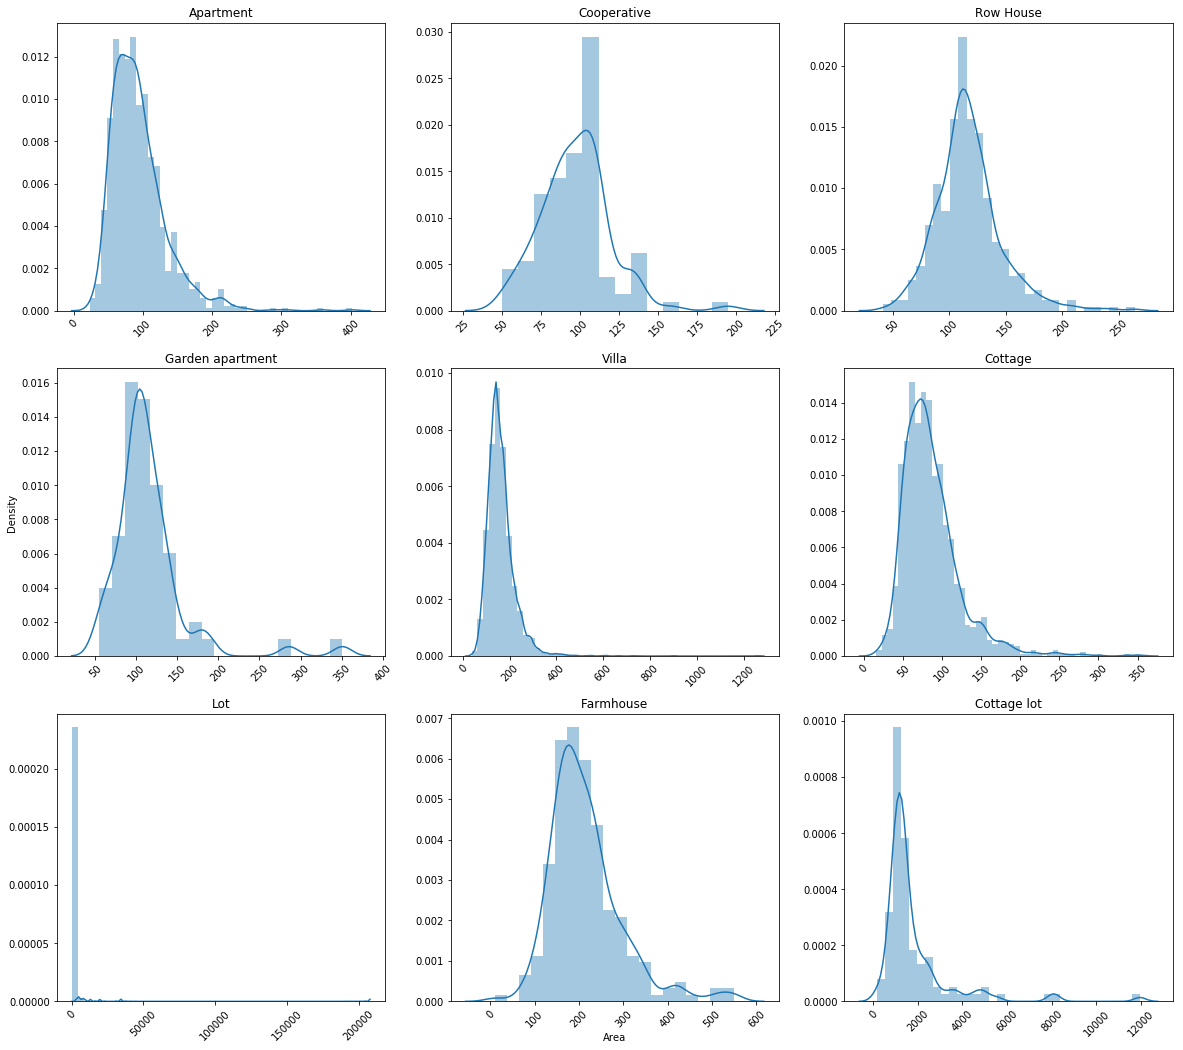

In [743]:
def subplot_distribution(df, loop_col, plot_col, drop_na):
    """
    Creates and plots subplots of distributions of plot_col for each column in loop_call.
    """
    unique_loop_col = df[loop_col].unique()
    
    total_subplots = len(unique_loop_col)
    count = 1
    if total_subplots // 3 == 3:
        x_label_center = True
    df_plot = df
    if drop_na:
        df_plot = df.loc[df[plot_col].dropna().index]
    plt.figure(figsize = [20, total_subplots*2]);
    for col in unique_loop_col:
        plt.subplot(math.ceil(total_subplots/3),3,count)
        try: 
            sb.distplot(df_plot[df_plot[loop_col] == col][plot_col])
        except:
            print('Failed to plot {}'.format(col)) 
        plt.xlabel('')
        plt.ticklabel_format(style='plain')
        plt.xticks(rotation = 45) 
        plt.title(col)
        if (x_label_center) & (count == total_subplots - 1):
            plt.xlabel(plot_col)
        elif (count == total_subplots) & ~(x_label_center):
            plt.xlabel(plot_col)          
        if count == 4:
            plt.ylabel('Density')
        count += 1
subplot_distribution(df, 'HomeType', 'Area', True)

Okay lot's of interesting takes here, but mainly the lot and the cottage lot are skewing our dataset with a few outliers.

Let's move on to the data as a whole.

In [744]:
df.query('HomeType == "Lot" & Area > 50000')

index        Address      Area         City HomeType  isNew   Latitude  \
7153  41399  Båstrupvej 15  207593.0  Skanderborg      Lot  False  55.998895   

      Longitude  PostalCode      Price  ... Sewers Basement  PriceDevelopment  \
7153   9.948583        8660  4495000.0  ...    NaN      NaN               NaN   

      Accessories  Heating  Windows  YearOfValuation Exterior  NetOwnerFee  \
7153          NaN      NaN      NaN              NaN      NaN          NaN   

      GrossOwnerFee  
7153            NaN  

[1 rows x 39 columns]

Okay, so one in particular.

How many rows do we have with data i all columns?

In [745]:
df.dropna()

Empty DataFrame
Columns: [index, Address, Area, City, HomeType, isNew, Latitude, Longitude, PostalCode, Price, ID, PaymentOnAccount, DistanceToShopping, DistanceToTransportation, DistanceToSchool, DistanceToForest, DistanceToWater, Balcony, Floors, Rooms, Toilets, Connection, LivingArea, YearOfConstruction, EstateValue, EnergyRating, Level, GroundArea, LandValue, Sewers, Basement, PriceDevelopment, Accessories, Heating, Windows, YearOfValuation, Exterior, NetOwnerFee, GrossOwnerFee]
Index: []

[0 rows x 39 columns]

Well that wasn't very encouraging. Let's try that again, but only with columns with more than 1000 rows of actual data.

In [746]:
complete_row_cols = df.columns[((df.shape[0]-df.isnull().sum()) > 1000)]
df_low_rows = df[complete_row_cols]
df_low_rows.head()

index                         Address  Area           City   HomeType  \
0      0   A.D. Jørgensens Vej 75, 2. 1.  35.0  Frederiksberg  Apartment   
1      1   Holger Danskes Vej 14, 3. th.  46.0  Frederiksberg  Apartment   
2     11              Lyøvej 5, st.. tv.  60.0  Frederiksberg  Apartment   
3     12  H. Schneekloths Vej 13, 5. th.  56.0  Frederiksberg  Apartment   
4     30            Howitzvej 61, 3. th.  67.0  Frederiksberg  Apartment   

   isNew   Latitude  Longitude  PostalCode      Price  ... LivingArea  \
0  False  55.680726  12.494705        2000  1350000.0  ...       35.0   
1  False  55.686615  12.538356        2000  2145000.0  ...       46.0   
2  False  55.682940  12.524527        2000  2875000.0  ...       77.0   
3  False  55.679928  12.506927        2000  2750000.0  ...       74.0   
4   True  55.680209  12.523998        2000  3195000.0  ...        NaN   

   YearOfConstruction  EstateValue  GroundArea  LandValue  PriceDevelopment  \
0              1991.0     780000.0         NaN   168300.0              -7.0   
1              1885.0    1100000.0         NaN   145000.0              -6.0   
2              1988.0    1600000.0         NaN   259100.0              -4.0   
3              1972.0    1350000.0         NaN   164300.0               0.0   
4                 NaN          NaN         NaN        NaN               NaN   

                                         Accessories  YearOfValuation  \
0  Alle nuværende hårde hvidevarer i lejligheden ...           2018.0   
1  Intuition gaskomfur komfur  - Matsui Fridge Do...           2018.0   
2  emhætte -  bordkomfur glaskeramisk -  indbygni...           2018.0   
3  De i lejligheden hårde hvidevarer medfølger i ...           2018.0   
4                                                NaN              NaN   

   NetOwnerFee  GrossOwnerFee  
0        5.249         4628.0  
1        8.313         7331.0  
2       10.446         9212.0  
3       10.075         8884.0  
4          NaN            NaN  

[5 rows x 26 columns]

In [747]:
df_low_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 26 columns):
index                 8515 non-null int64
Address               8515 non-null object
Area                  8505 non-null float64
City                  8515 non-null object
HomeType              8515 non-null object
isNew                 8515 non-null bool
Latitude              8221 non-null float64
Longitude             8221 non-null float64
PostalCode            8515 non-null int64
Price                 8515 non-null float64
ID                    8515 non-null object
DistanceToShopping    1227 non-null float64
DistanceToSchool      1013 non-null float64
Floors                1077 non-null float64
Rooms                 1322 non-null float64
Toilets               1021 non-null float64
LivingArea            1330 non-null float64
YearOfConstruction    1327 non-null float64
EstateValue           1268 non-null float64
GroundArea            1093 non-null float64
LandValue             12

In [748]:
df_low_rows.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 84 to 1439
Data columns (total 26 columns):
index                 428 non-null int64
Address               428 non-null object
Area                  428 non-null float64
City                  428 non-null object
HomeType              428 non-null object
isNew                 428 non-null bool
Latitude              428 non-null float64
Longitude             428 non-null float64
PostalCode            428 non-null int64
Price                 428 non-null float64
ID                    428 non-null object
DistanceToShopping    428 non-null float64
DistanceToSchool      428 non-null float64
Floors                428 non-null float64
Rooms                 428 non-null float64
Toilets               428 non-null float64
LivingArea            428 non-null float64
YearOfConstruction    428 non-null float64
EstateValue           428 non-null float64
GroundArea            428 non-null float64
LandValue             428 non-null float64
P

Alright! Not the largest number of rows, but we at least got some data to work with.

We have some options at this point:
1. Only use the columns with a high quality
1. Discard the some of the outliers
2. Use all columns and all rows and use the lack of information as a category for the lacking columns
3. Drop rows with missing values to accomodate the features with a lower quality

## Analysis 

### How much does location matter?
Before we start with the modelling, let's just enjoy the following plot.

In the data we have the latitude and longitude of all the listings, so we can plot them along with the prices to create a map of the listings in Denmark!

First, here's a picture for reference.

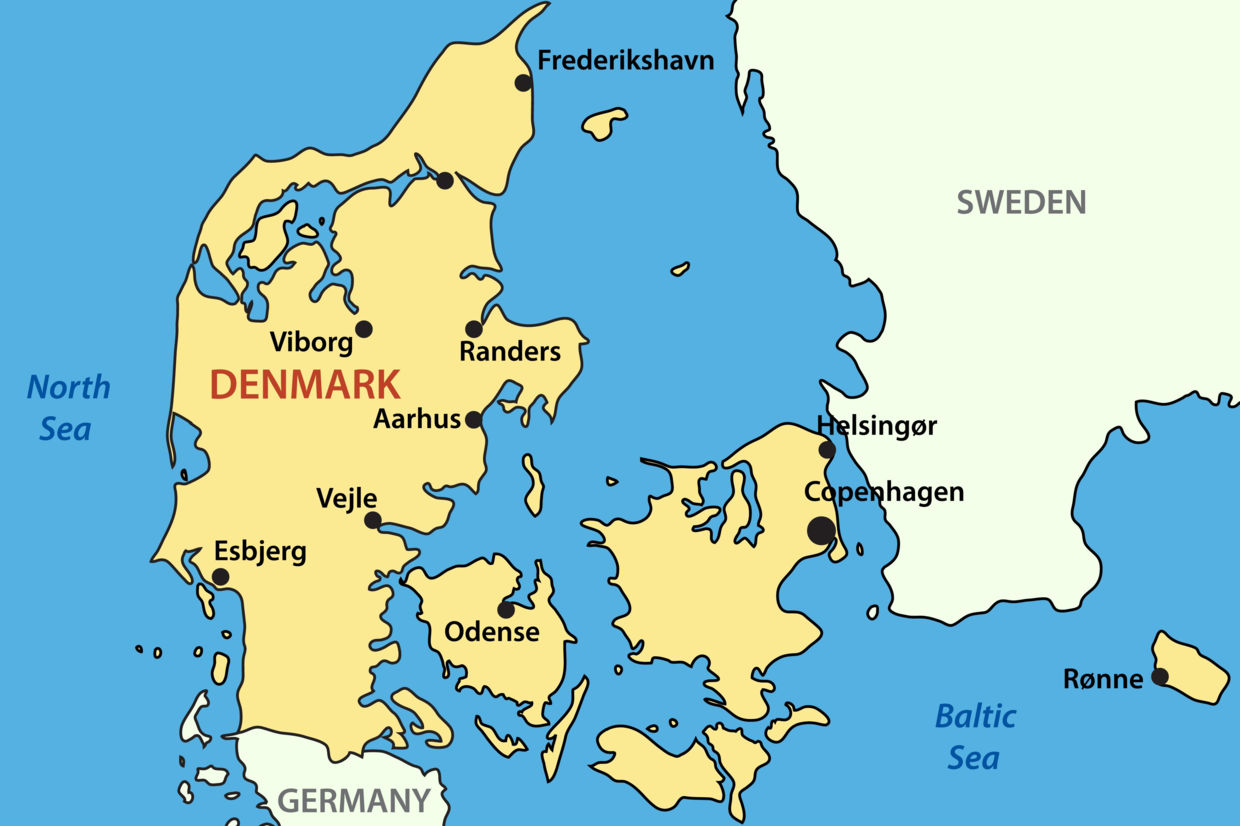

In [491]:
from IPython.display import Image
Image("img/denmark.jpeg")

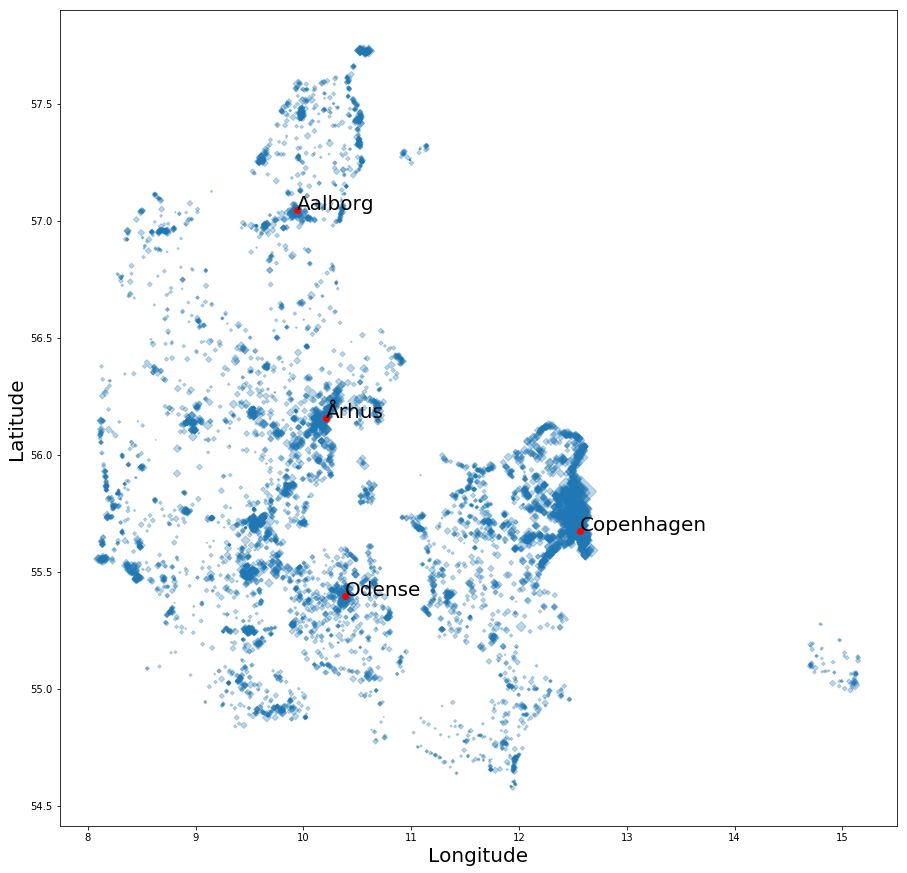

In [974]:
scale = (df['Price']/df['Price'].max()) * 500 # abbritary number for the scale
plt.figure(figsize = [15, 15])
plt.scatter(data = df, x = 'Longitude', y = 'Latitude', s = scale, alpha = 0.3, marker = 'D')
#plt.legend({'Price'});
plt.xlabel('Longitude', size = '20');
plt.ylabel('Latitude', size = '20');
plt.plot(9.935932,57.046707, 'o', c = 'r')
plt.text(9.935932,57.046707,'Aalborg', size = '20');
plt.plot(10.210365,56.156635, 'o', c = 'r')
plt.text(10.210365,56.156635,'Århus', size = '20');
plt.plot(12.568337,55.676098, 'o', c = 'r')
plt.text(12.568337,55.676098,'Copenhagen', size = '20');
plt.plot(10.38831,55.39594, 'o', c = 'r')
plt.text(10.38831,55.39594,'Odense', size = '20');
plt.savefig('img/location.svg')

Look at this thing! It's beautiful, if I do say so myself. But not only that, it also provides indication of a trend.
It looks like the areas arround Århus, Copenhagen and Odense have the largest density of listings (this is unsurpricing), but Copenhagen appears to have the highest prices with a few oddballs here an there. So there's definetly a regional component to the pricing.

### Can we predict listing prices?
Using a random forest regressor, let's see if we are able to predict the prices using the features above.

First let's setup the sets of data mentioned above, to see how the different scenarios affect the model.

In [842]:
df_few_col = df[['Area','HomeType','Latitude',
              'Longitude','PostalCode','Price']]
df_few_row = df_low_rows.drop(columns = ['Address','City','ID','Accessories'])

In [843]:
df_few_col_wo_outliers = df_few_col.query('Area < 50000 & Price < 30000000')
df_few_row_wo_outliers = df_few_row.query('Area < 50000 & Price < 30000000')

In [844]:
df_few_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 6 columns):
Area          8505 non-null float64
HomeType      8515 non-null object
Latitude      8221 non-null float64
Longitude     8221 non-null float64
PostalCode    8515 non-null int64
Price         8515 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 399.2+ KB


In [845]:
df_few_col_wo_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8499 entries, 0 to 8514
Data columns (total 6 columns):
Area          8499 non-null float64
HomeType      8499 non-null object
Latitude      8206 non-null float64
Longitude     8206 non-null float64
PostalCode    8499 non-null int64
Price         8499 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


In [846]:
df_few_row.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 84 to 1439
Data columns (total 23 columns):
index                 428 non-null int64
Area                  428 non-null float64
HomeType              428 non-null object
isNew                 428 non-null bool
Latitude              428 non-null float64
Longitude             428 non-null float64
PostalCode            428 non-null int64
Price                 428 non-null float64
DistanceToShopping    428 non-null float64
DistanceToSchool      428 non-null float64
Floors                428 non-null float64
Rooms                 428 non-null float64
Toilets               428 non-null float64
LivingArea            428 non-null float64
YearOfConstruction    428 non-null float64
EstateValue           428 non-null float64
GroundArea            428 non-null float64
LandValue             428 non-null float64
PriceDevelopment      428 non-null float64
YearOfValuation       428 non-null float64
NetOwnerFee           428 non-null float6

In [847]:
df_few_row_wo_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427 entries, 84 to 1439
Data columns (total 23 columns):
index                 427 non-null int64
Area                  427 non-null float64
HomeType              427 non-null object
isNew                 427 non-null bool
Latitude              427 non-null float64
Longitude             427 non-null float64
PostalCode            427 non-null int64
Price                 427 non-null float64
DistanceToShopping    427 non-null float64
DistanceToSchool      427 non-null float64
Floors                427 non-null float64
Rooms                 427 non-null float64
Toilets               427 non-null float64
LivingArea            427 non-null float64
YearOfConstruction    427 non-null float64
EstateValue           427 non-null float64
GroundArea            427 non-null float64
LandValue             427 non-null float64
PriceDevelopment      427 non-null float64
YearOfValuation       427 non-null float64
NetOwnerFee           427 non-null float6

In order to use catagorical columns, we need to transform them. Luckily there's already a function from sklearn we can use.

In both datasets (and with or without the outliers), we only need to transform the home type, so let's use the same transformation to have a common interpretability.

In [848]:
le = preprocessing.LabelEncoder()
le.fit(df['HomeType'].unique())
le.classes_

array(['Apartment', 'Cooperative', 'Cottage', 'Cottage lot', 'Farmhouse',
       'Garden apartment', 'Lot', 'Row House', 'Villa'], dtype=object)

In [849]:
df_few_col['HomeType_cat'] = le.transform(df_few_col['HomeType'])
df_few_col_wo_outliers['HomeType_cat'] = le.transform(df_few_col_wo_outliers['HomeType'])
df_few_row['HomeType_cat'] = le.transform(df_few_row['HomeType'])
df_few_row_wo_outliers['HomeType_cat'] = le.transform(df_few_row_wo_outliers['HomeType'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Now we can fit the random forest regressor. Note we do have to drop rows with NaN's in numeric columns.

In [850]:
df_few_col.dropna(axis = 0, how = 'any', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [858]:
regr_few_col = ensemble.RandomForestRegressor(random_state=42)
X = df_few_col.drop(columns = ['Price', 'HomeType'])
y = df_few_col['Price']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr_few_col.fit(X_train, y_train)
regr_few_col.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6382079031104045

In [852]:
df_few_col_wo_outliers.dropna(axis = 0, how = 'any', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [865]:
regr_few_col_wo = ensemble.RandomForestRegressor(random_state=42)
X = df_few_col_wo_outliers.drop(columns = ['Price', 'HomeType'])
y = df_few_col_wo_outliers['Price']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr_few_col_wo.fit(X_train, y_train)
regr_few_col_wo.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7069460790036319

In [854]:
df_few_row.dropna(axis = 0, how = 'any', inplace = True)

In [860]:
regr_few_row = ensemble.RandomForestRegressor(random_state=42)
X = df_few_row.drop(columns = ['Price', 'HomeType'])
y = df_few_row['Price']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr_few_row.fit(X_train, y_train)
regr_few_row.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6002474247696814

In [856]:
df_few_row_wo_outliers.dropna(axis = 0, how = 'any', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [861]:
regr_few_row_wo = ensemble.RandomForestRegressor(random_state=42)
X = df_few_row_wo_outliers.drop(columns = ['Price', 'HomeType'])
y = df_few_row_wo_outliers['Price']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr_few_row_wo.fit(X_train, y_train)
regr_few_row_wo.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.4828779802390904

Alright so our best bet seems to be the dataset with few rows, but lots of columns without the outliers.

Let's have a closer look at the model sample from that ensemble.

In [862]:
regr_few_col_wo

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Okay, the standards are 10 trees in the forest, minium 2 samples to split and at least 1 sample in each leaf.

Let's have a look at one of the trees:

In [985]:
dot_data = tree.export_graphviz(regr_few_col_wo.estimators_[2], out_file=None, 
                      feature_names=['Area','Latitude','Longitude','PostalCode','HomeType_cat'],    
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Okay, so clearly this is a very complex model, which may not be a good thing. Let's tinker with the parameters.

In [886]:
regr_few_col_wo = ensemble.RandomForestRegressor(random_state=42, max_depth = 15,  n_estimators = 100)
X = df_few_col_wo_outliers.drop(columns = ['Price', 'HomeType'])
y = df_few_col_wo_outliers['Price']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr_few_col_wo.fit(X_train, y_train)
regr_few_col_wo.score(X_test, y_test)

0.7168461500020331

Turns out there probably isn't too much to gain, but we can limit the complexity of each tree to 15 layers without losing predictive power as long as we add more trees. Let's checkout a tree again:

In [989]:
dot_data = tree.export_graphviz(regr_few_col_wo.estimators_[2], out_file = None, 
                      feature_names=['Area','Latitude','Longitude','PostalCode','HomeType_cat'],    
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

At least it's a bit better.

Wrapping up the question: Can we predict listing prices? Well we can explain 70% of the variance in price.

Let's test it with a real life example:
Jumping to a different real estate company, I've found the following [listing](https://www.nybolig.dk/ejerlejlighed/2000/soendrefasanvej/260349/329399).

It's an apartment with 94 squaremeters of area in the postal code 2000. The longitude and latitude are 55.669332 and 12.517642 (courtesy of google maps) with a listing price of 3850000 DKK.

In [891]:
le.transform(['Apartment'])

array([0], dtype=int64)

In [892]:
regr_few_col_wo.predict([[94, 55.669332, 12.517642, 2000, 0]])

array([4321535.61777778])

Didn't quite hit the mark, or maybe this listing is great oportunity!

### What features are most important?
We can use the regressor to output the importance of each feature:

In [960]:
regr_few_col_wo.feature_importances_

array([0.4207236 , 0.1080217 , 0.13174996, 0.30263717, 0.03686757])

In [993]:
feature_importance = np.array(regr_few_col_wo.feature_importances_)*100
feature_importance
p = feature_importance.argsort()
feature_importance = feature_importance[p]
labels = np.array(['Area','Latitude','Longitude','Postal Code','Home Type'])[p]

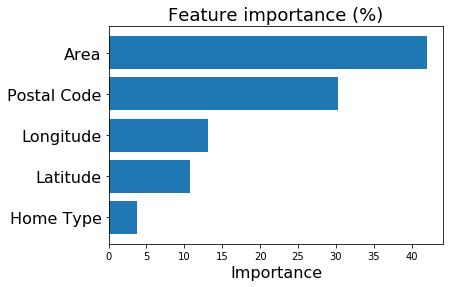

In [997]:
plt.barh(y = labels, width = feature_importance)
plt.yticks(size = 16);
plt.xlabel('Importance', size = 16);
plt.title('Feature importance (%)', size = 18);
plt.savefig('img/feature_importance.svg')